In [47]:
import mne # package for reading edf data
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, sosfreqz  
from sklearn.decomposition import PCA
from data_tools import * # i made all t # i made all the functions into a python file
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
band = [4,8,12,30,45] #4 bands
window_size = 2000 #Averaging band power of 2 sec
step_size = 125 #1/8 second step
sample_rate = 1000 #Each 0.125 sec update once

In [3]:
bandNames = ['theta', 'alpha', 'beta', 'gamma']
colNames = ['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3',
       'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
finalHeaderNames = []
for header in colNames:
    for bandName in bandNames:
        finalHeaderNames.append(bandName + '_' + header)

In [4]:
def FFT_Processing (clip):
    meta = pd.DataFrame(data=[], columns=finalHeaderNames)
    start = 0
    while start + window_size < clip.shape[0]:
        metaClip = pd.DataFrame(data=[], columns=finalHeaderNames)
        meta_array = []
        meta_data = [] #meta vector for analysis
        for (columnName, columnData) in clip.iteritems():
            X = columnData[start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
            Y = quick_bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
            meta_data.append(list(Y[1]))
        metaClip = pd.DataFrame(data=[np.array(meta_data).flatten()], columns=finalHeaderNames)
        meta = meta.append(metaClip)
        start = start + step_size
    return meta.reset_index(drop=True)

In [75]:
# Create empty lists to store our data
train_data = []
train_labels = []
test_data = []
test_labels = []
train_pca = []
test_pca = []

test_set = np.random.choice(124, size=24, replace=False)

# Going through all 124 trials
for subject in range(28,32):
    for trial in range(2,6):
        df = get_recording_events(subject, trial)
        labels = df.groupby('song_clip').head(1).TARGET.to_list() # Should be an array of 10 labels for each of the songs played in this trial
        recordings = [df[df.song_clip==x].drop(columns=['song_clip','Number','TARGET','time']) for x in df.song_clip.unique()] 
        # Going through all 10 playings
        for playing in range(0,10):
            recording = recordings[playing]
            if recording.shape[0] < 16000:
                continue
            recording = recording.iloc[:16000,:]

            # FFT
            fft_recording = FFT_Processing(recording)

            # PCA
            pca = PCA(n_components=5)
            pca_clip = pca.fit(fft_recording, train_labels).transform(fft_recording).T.reshape(-1)
           
            features = np.append(pca_clip, consecutive_window_powers(recording, 16000).iloc[0])
            features = np.append(features, consecutive_window_powers(recording, 16000, ratio=False).iloc[0])

            if subject == 31:
                test_data.append(recording)
                test_labels.append(labels[playing])
                test_pca.append(features)
            else:
                train_data.append(recording)
                train_labels.append(labels[playing])
                train_pca.append(features)
                    
print('Processing completed!')

e
  Power_Ratio = Power / sum(Power)
Extracting EDF parameters from c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data\sub-29\eeg\sub-29_task-run3_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data_tools.py:16: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  data = mne.io.read_raw_edf(fileName)
c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data_tools.py:125: RuntimeWarning: invalid value encountered in true_divide
  Power_Ratio = Power / sum(Power)
c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data_tools.py:125: RuntimeWarning: invalid value encountered in true_divide
  Power_Ratio = Power / sum(Power)
c:\Users\Jack Sheridan\Documents\COGS189\COGS189-final-project\data_tools.py:125: RuntimeWarning: invalid value encountered in true_divide
  Power_Ratio = Power / sum(Power)
c:\Users\Jack Sheridan\Documents\COG

In [9]:
def trinarizer(x):
    """divides the feature space by perceived arousal level of emotion (high/low)"""
    if x in ['SURPRISE','HIGH VALENCE', 'HIGH ENERGY','HIGH TENSION']:
        return 2
    elif x in ['HAPPY', 'FEAR', 'ANGER']:
        return 1
    return 0

In [23]:
def binarizer(x):
    """divides the feature space by perceived arousal level of emotion (high/low)"""
    if x in ['HAPPY', 'FEAR', 'ANGER', 'SURPRISE','HIGH VALENCE', 'HIGH ENERGY','HIGH TENSION']:
        return 1
    return 0

In [39]:
print(train_pca[0].shape)

(560,)


In [41]:
np.array(train_pca)

array([[ 0.14822729,  0.00298056, -0.0257153 , ...,  0.15047975,
         0.03979312, -0.04227637],
       [-0.27243   , -0.19828714, -0.12766773, ..., -0.01250738,
        -0.02312222,  0.01600101],
       [ 0.39907623,  0.41581839,  0.39757554, ...,  0.09822386,
         0.14701383,  0.05405844],
       ...,
       [ 0.29089306,  0.28529067,  0.27675349, ...,  0.01634841,
         0.00261091,  0.07284043],
       [ 0.1368309 ,  0.23100033,  0.22672103, ..., -0.11808843,
        -0.06733835, -0.13353184],
       [-0.06445419, -0.07494244, -0.06725531, ...,  0.03535598,
         0.06335547,  0.08480286]])

In [69]:
train_bin = [binarizer(train_label) for train_label in train_labels]
test_bin = [binarizer(test_label) for test_label in test_labels]


grad = GradientBoostingClassifier(n_estimators=500)
grad_bin = ranTree.fit(np.array(train_pca), train_labels).predict(np.array(test_pca))

predictions = pd.DataFrame({'prediction': grad_bin, 'label': test_labels})
predictions['correct'] = predictions['prediction'] == predictions['label']
print(predictions)
sum(predictions['correct'])/len(test_bin)

      prediction         label  correct
0          ANGER        TENDER    False
1       SURPRISE      SURPRISE     True
2     LOW ENERGY      SURPRISE    False
3    LOW TENSION   LOW TENSION     True
4       SURPRISE         ANGER    False
5          ANGER          FEAR    False
6     LOW ENERGY         ANGER    False
7       SURPRISE   LOW TENSION    False
8       SURPRISE      SURPRISE     True
9       SURPRISE         HAPPY    False
10  HIGH TENSION      SURPRISE    False
11  HIGH TENSION         ANGER    False
12  HIGH TENSION    LOW ENERGY    False
13         ANGER  HIGH TENSION    False
14         ANGER         ANGER     True
15      SURPRISE      SURPRISE     True
16      SURPRISE         HAPPY    False
17    LOW ENERGY           SAD    False
18         ANGER  HIGH VALENCE    False
19      SURPRISE   LOW VALENCE    False
20         ANGER    LOW ENERGY    False
21      SURPRISE    LOW ENERGY    False
22      SURPRISE   LOW TENSION    False
23  HIGH TENSION  HIGH TENSION     True


0.21052631578947367

In [70]:
train_bin = [binarizer(train_label) for train_label in train_labels]
test_bin = [binarizer(test_label) for test_label in test_labels]


ranTree = RandomForestClassifier(n_estimators=200)
ranTree_bin = ranTree.fit(np.array(train_pca), train_labels).predict(np.array(test_pca))

predictions = pd.DataFrame({'prediction': ranTree_bin, 'label': test_labels})
predictions['correct'] = predictions['prediction'] == predictions['label']
print(predictions)
sum(predictions['correct'])/len(test_bin)

      prediction         label  correct
0          ANGER        TENDER    False
1       SURPRISE      SURPRISE     True
2       SURPRISE      SURPRISE     True
3    LOW TENSION   LOW TENSION     True
4       SURPRISE         ANGER    False
5          ANGER          FEAR    False
6          ANGER         ANGER     True
7       SURPRISE   LOW TENSION    False
8       SURPRISE      SURPRISE     True
9       SURPRISE         HAPPY    False
10  HIGH TENSION      SURPRISE    False
11      SURPRISE         ANGER    False
12         ANGER    LOW ENERGY    False
13         ANGER  HIGH TENSION    False
14         ANGER         ANGER     True
15      SURPRISE      SURPRISE     True
16      SURPRISE         HAPPY    False
17    LOW ENERGY           SAD    False
18         ANGER  HIGH VALENCE    False
19    LOW ENERGY   LOW VALENCE    False
20         ANGER    LOW ENERGY    False
21   LOW VALENCE    LOW ENERGY    False
22         ANGER   LOW TENSION    False
23  HIGH TENSION  HIGH TENSION     True


0.2631578947368421

In [71]:
train_bin = [binarizer(train_label) for train_label in train_labels]
test_bin = [binarizer(test_label) for test_label in test_labels]


decTree = DecisionTreeClassifier()
dec_bin = decTree.fit(np.array(train_pca), train_labels).predict(np.array(test_pca))

predictions = pd.DataFrame({'prediction': dec_bin, 'label': test_labels})
predictions['correct'] = predictions['prediction'] == predictions['label']
print(predictions)
sum(predictions['correct'])/len(test_bin)

      prediction         label  correct
0    LOW TENSION        TENDER    False
1     LOW ENERGY      SURPRISE    False
2   HIGH TENSION      SURPRISE    False
3     LOW ENERGY   LOW TENSION    False
4    LOW VALENCE         ANGER    False
5    LOW VALENCE          FEAR    False
6          ANGER         ANGER     True
7    LOW TENSION   LOW TENSION     True
8    LOW TENSION      SURPRISE    False
9   HIGH TENSION         HAPPY    False
10   LOW TENSION      SURPRISE    False
11        TENDER         ANGER    False
12         ANGER    LOW ENERGY    False
13      SURPRISE  HIGH TENSION    False
14  HIGH VALENCE         ANGER    False
15    LOW ENERGY      SURPRISE    False
16   LOW VALENCE         HAPPY    False
17   LOW TENSION           SAD    False
18   HIGH ENERGY  HIGH VALENCE    False
19   LOW TENSION   LOW VALENCE    False
20   LOW VALENCE    LOW ENERGY    False
21  HIGH TENSION    LOW ENERGY    False
22    LOW ENERGY   LOW TENSION    False
23   LOW VALENCE  HIGH TENSION    False


0.10526315789473684

In [72]:
train_bin = [binarizer(train_label) for train_label in train_labels]
test_bin = [binarizer(test_label) for test_label in test_labels]


mlp = MLPClassifier(hidden_layer_sizes=(200, 100, 1))
mlp_bin = mlp.fit(np.array(train_pca), train_labels).predict(np.array(test_pca))




predictions = pd.DataFrame({'prediction': mlp_bin, 'label': test_labels})
predictions['correct'] = predictions['prediction'] == predictions['label']
print(predictions)
sum(predictions['correct'])/len(test_bin)


     prediction         label  correct
0         ANGER        TENDER    False
1         ANGER      SURPRISE    False
2         ANGER      SURPRISE    False
3   LOW TENSION   LOW TENSION     True
4      SURPRISE         ANGER    False
5         ANGER          FEAR    False
6      SURPRISE         ANGER    False
7         ANGER   LOW TENSION    False
8   LOW TENSION      SURPRISE    False
9         ANGER         HAPPY    False
10        ANGER      SURPRISE    False
11  LOW TENSION         ANGER    False
12        ANGER    LOW ENERGY    False
13        ANGER  HIGH TENSION    False
14        ANGER         ANGER     True
15     SURPRISE      SURPRISE     True
16     SURPRISE         HAPPY    False
17        ANGER           SAD    False
18        ANGER  HIGH VALENCE    False
19        ANGER   LOW VALENCE    False
20        ANGER    LOW ENERGY    False
21  LOW TENSION    LOW ENERGY    False
22     SURPRISE   LOW TENSION    False
23        ANGER  HIGH TENSION    False
24     SURPRISE  HIGH VAL

0.13157894736842105

In [73]:
train_bin = [binarizer(train_label) for train_label in train_labels]
test_bin = [binarizer(test_label) for test_label in test_labels]

ldabin = LinearDiscriminantAnalysis(n_components=1)
X_r2bin = ldabin.fit(train_pca, train_labels).transform(train_pca)

knn = KNeighborsClassifier(n_neighbors=3)
knn_bin = knn.fit(X_r2bin, train_labels).predict(ldabin.transform(test_pca))
predictions = pd.DataFrame({'prediction': knn_bin, 'label': test_labels})
predictions['correct'] = predictions['prediction'] == predictions['label']
print(predictions)
sum(predictions['correct'])/len(test_bin)



      prediction         label  correct
0           FEAR        TENDER    False
1       SURPRISE      SURPRISE     True
2          HAPPY      SURPRISE    False
3    LOW TENSION   LOW TENSION     True
4           FEAR         ANGER    False
5          HAPPY          FEAR    False
6       SURPRISE         ANGER    False
7    LOW TENSION   LOW TENSION     True
8          ANGER      SURPRISE    False
9    LOW TENSION         HAPPY    False
10  HIGH TENSION      SURPRISE    False
11  HIGH TENSION         ANGER    False
12  HIGH TENSION    LOW ENERGY    False
13         ANGER  HIGH TENSION    False
14         HAPPY         ANGER    False
15  HIGH TENSION      SURPRISE    False
16         ANGER         HAPPY    False
17         HAPPY           SAD    False
18   HIGH ENERGY  HIGH VALENCE    False
19   LOW TENSION   LOW VALENCE    False
20   HIGH ENERGY    LOW ENERGY    False
21           SAD    LOW ENERGY    False
22   LOW TENSION   LOW TENSION     True
23  HIGH TENSION  HIGH TENSION     True


0.13157894736842105

In [74]:
train_bin = [binarizer(train_label) for train_label in train_labels]
test_bin = [binarizer(test_label) for test_label in test_labels]

ldabin = LinearDiscriminantAnalysis(n_components=1)
X_r2bin = ldabin.fit(train_pca, train_bin).transform(train_pca)

gnb = GaussianNB()
x_gnb = gnb.fit(X_r2bin, train_bin).predict(ldabin.transform(test_pca))
predictions = pd.DataFrame({'prediction': x_gnb, 'label': test_bin})
predictions['correct'] = predictions['prediction'] == predictions['label']
print(predictions)
sum(predictions['correct'])/len(test_bin)

    prediction  label  correct
0            0      0     True
1            1      1     True
2            0      1    False
3            0      0     True
4            1      1     True
5            1      1     True
6            0      1    False
7            1      0    False
8            0      1    False
9            0      1    False
10           1      1     True
11           1      1     True
12           1      0    False
13           1      1     True
14           1      1     True
15           0      1    False
16           0      1    False
17           0      0     True
18           1      1     True
19           1      0    False
20           0      0     True
21           0      0     True
22           1      0    False
23           0      1    False
24           0      1    False
25           0      1    False
26           0      1    False
27           0      0     True
28           1      1     True
29           0      1    False
30           0      1    False
31      

0.4473684210526316

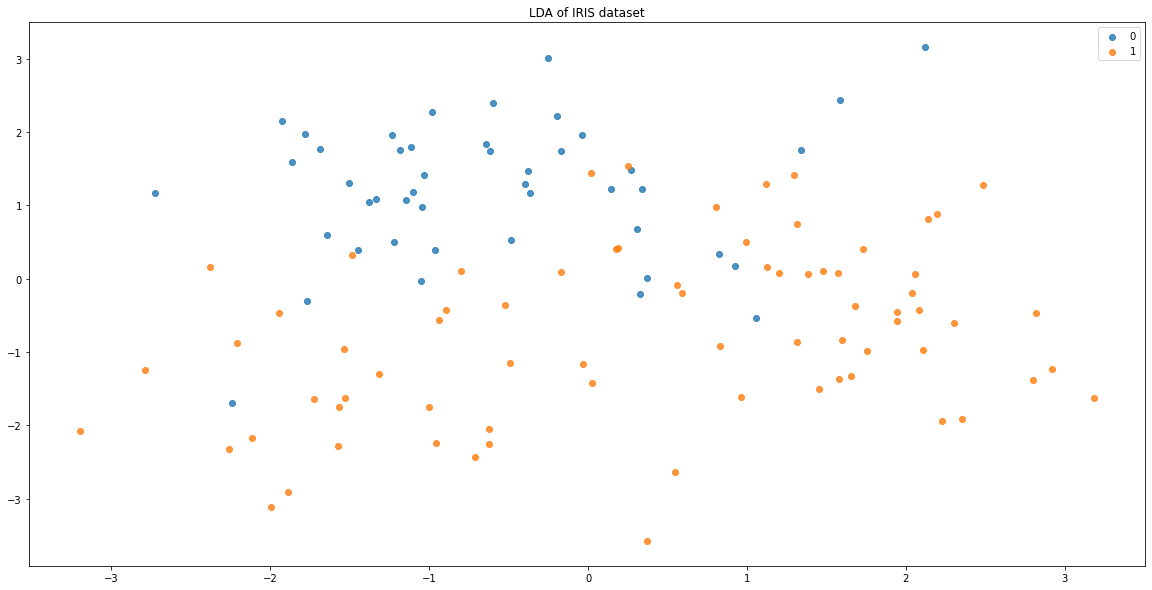

In [28]:
plt.figure(figsize=(20,10))
target_bin = [0, 1]
for target_name in target_bin:
    plt.scatter(X_r2[[index for index, value in enumerate(train_bin) if value == target_name], 0], X_r2[[index for index, value in enumerate(train_bin) if value == target_name], 1], alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')
plt.show()

In [10]:
train_trin = [trinarizer(train_label) for train_label in train_labels]

In [11]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(train_pca, train_trin).transform(train_pca)

In [19]:
print(test_data)

76   1.117869   1.559928   
64002 -30.421208  25.662349  23.056349   4.170146   0.658331   1.400334   

              F8         T3         C3        Cz         C4         T4  \
48003  -2.352199   9.912978 -19.269232 -6.867744 -20.309508  -7.852417   
48004 -11.326371   9.174341 -17.067996 -5.833468 -21.476877  -6.734560   
48005 -19.060211  11.917850 -18.233356 -4.255011 -21.187924  -7.498245   
48006 -10.480027   9.854942 -19.208086 -3.778162 -21.430645  -6.037283   
48007  -6.481777   6.541627 -18.233356 -5.447132 -19.361743  -8.140182   
...          ...        ...        ...       ...        ...        ...   
63998 -14.201025  50.395564  13.903957  1.796111 -11.444440   3.470033   
63999 -10.976160  44.576159  12.238644  0.939549 -10.496675  -4.255353   
64000  -8.393349  32.805450  11.317866  0.616131  -7.422219  -4.598458   
64001  -7.868032  30.563159   9.120228  0.482569  -4.671389  -3.845841   
64002  -7.736702  38.529887  11.483318  0.828064   4.829375  13.099096   

       

In [18]:
print(lda.transform(test_data))

ValueError: Found array with dim 3. Estimator expected <= 2.

In [21]:
gnb = GaussianNB()
x_gnb = gnb.fit(X_r2, train_trin).predict(lda.transform(test_pca))
print(x_gnb)

[0 1 0 0 1 1 0 2 0 0 1 2 1 0 1 0 0 0 1 1 0 0 2 0 2 0 1 1 0 0 0 2 2 1 1 2 1
 0]


In [22]:
predictions = pd.DataFrame({'prediction': x_gnb, 'label': test_trin})
predictions['correct'] = predictions['prediction'] == predictions['label']
print(predictions)
sum(predictions['correct'])/len(test_trin)

    prediction  label  correct
0            0      0     True
1            1      2    False
2            0      2    False
3            0      0     True
4            1      1     True
5            1      1     True
6            0      1    False
7            2      0    False
8            0      2    False
9            0      1    False
10           1      2    False
11           2      1    False
12           1      0    False
13           0      2    False
14           1      1     True
15           0      2    False
16           0      1    False
17           0      0     True
18           1      2    False
19           1      0    False
20           0      0     True
21           0      0     True
22           2      0    False
23           0      2    False
24           2      2     True
25           0      2    False
26           1      2    False
27           1      0    False
28           0      2    False
29           0      2    False
30           0      2    False
31      

0.2894736842105263

In [6]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(train_pca, train_labels).transform(train_pca)

In [39]:
X_r2

LinearDiscriminantAnalysis(n_components=2)

In [13]:
gnb = GaussianNB()
x_gnb = gnb.fit(X_r2, train_labels).predict(X_r2)


In [43]:
print(X_r2)

[[ 0.06566548  0.2613639 ]
 [ 0.0036468  -0.03392569]
 [-0.29899653  0.70832979]
 ...
 [-0.012651    0.06699508]
 [-0.25297529  0.07876465]
 [ 0.19051791  0.04111023]]


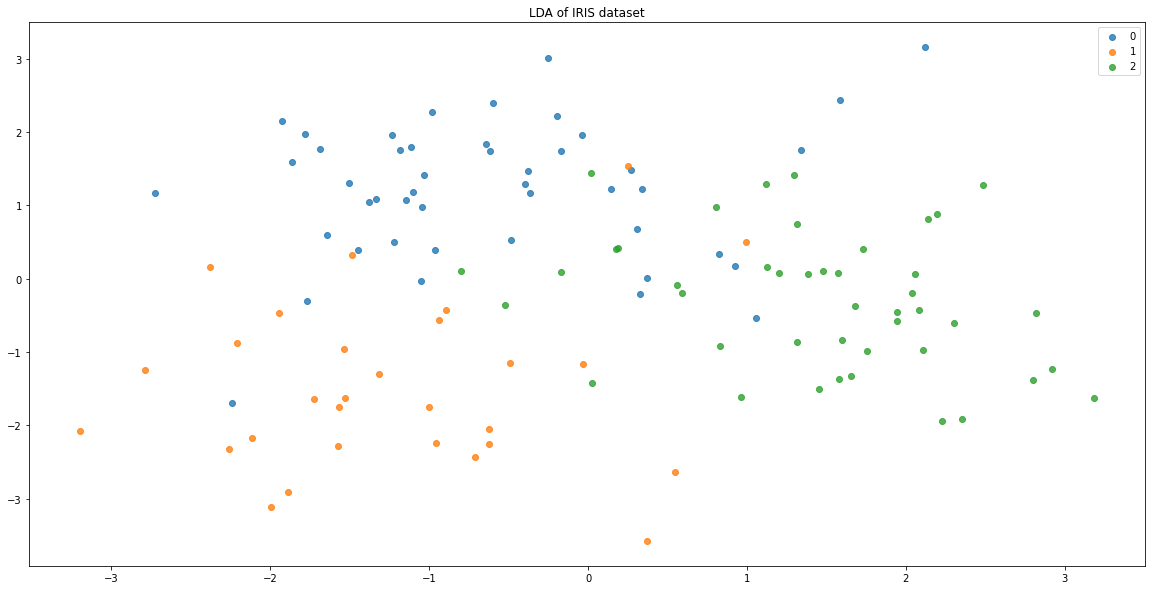

In [12]:
plt.figure(figsize=(20,10))
target_names = ['HAPPY', 'FEAR', 'ANGER', 'SURPRISE','HIGH VALENCE', 'LOW VALENCE', 'HIGH ENERGY', 'LOW ENERGY', 'HIGH TENSION', 'LOW TENSION', 'SAD', 'TENDER']
target_bin = [0, 1, 2]
for target_name in target_bin:
    plt.scatter(X_r2[[index for index, value in enumerate(train_trin) if value == target_name], 0], X_r2[[index for index, value in enumerate(train_trin) if value == target_name], 1], alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')
plt.show()

In [15]:

test_trin = [trinarizer(test_label) for test_label in test_labels]
predictions = pd.DataFrame({'prediction': lda.predict(test_pca), 'label': test_trin})
predictions['correct'] = predictions['prediction'] == predictions['label']
print(predictions)
sum(predictions['correct'])/len(test_trin)

    prediction  label  correct
0            0      0     True
1            1      2    False
2            0      2    False
3            0      0     True
4            1      1     True
5            1      1     True
6            0      1    False
7            2      0    False
8            0      2    False
9            0      1    False
10           1      2    False
11           2      1    False
12           1      0    False
13           0      2    False
14           1      1     True
15           0      2    False
16           0      1    False
17           0      0     True
18           1      2    False
19           1      0    False
20           0      0     True
21           2      0    False
22           2      0    False
23           0      2    False
24           2      2     True
25           0      2    False
26           1      2    False
27           1      0    False
28           0      2    False
29           0      2    False
30           0      2    False
31      

0.2631578947368421

In [7]:
X_r2.shape

(1171, 2)

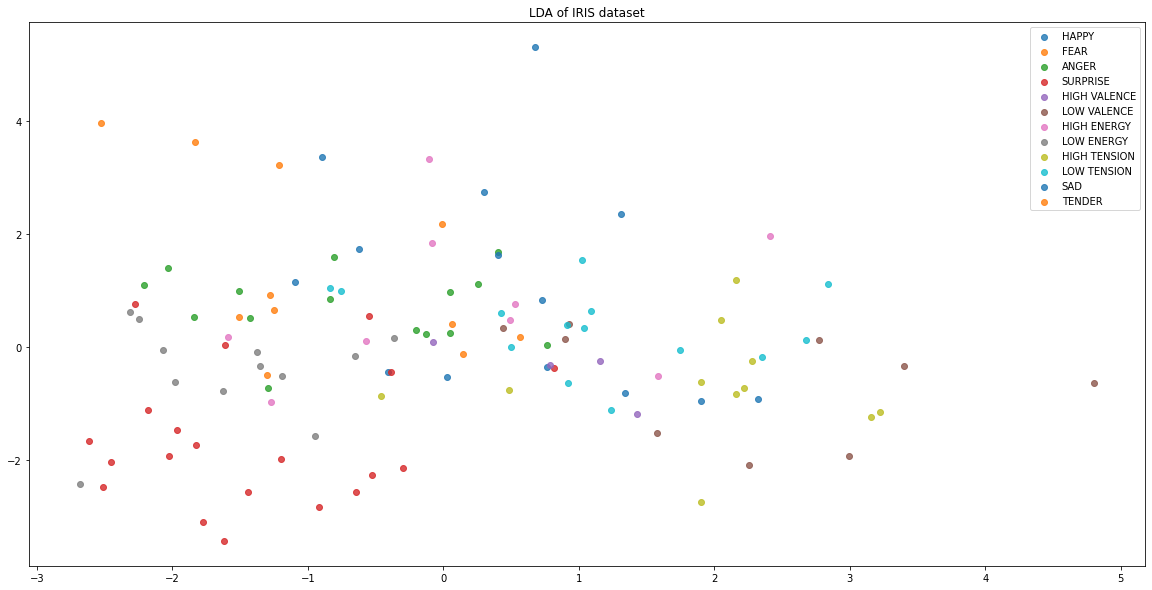

In [7]:
plt.figure(figsize=(20,10))
target_names = ['HAPPY', 'FEAR', 'ANGER', 'SURPRISE','HIGH VALENCE', 'LOW VALENCE', 'HIGH ENERGY', 'LOW ENERGY', 'HIGH TENSION', 'LOW TENSION', 'SAD', 'TENDER']

for target_name in target_names:
    plt.scatter(X_r2[[index for index, value in enumerate(train_labels) if value == target_name], 0], X_r2[[index for index, value in enumerate(train_labels) if value == target_name], 1], alpha=.8,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')
plt.show()

In [33]:
test_bin = [binarizer(test_label) for test_label in test_labels]

In [8]:
predictions = pd.DataFrame({'prediction': lda.predict(test_pca), 'label': test_labels})
predictions['correct'] = predictions['prediction'] == predictions['label']
print(predictions)
print(sum(predictions['correct'])/len(test_labels))

      prediction         label  correct
0          ANGER        TENDER    False
1          ANGER      SURPRISE    False
2           FEAR      SURPRISE    False
3    LOW TENSION   LOW TENSION     True
4          ANGER         ANGER     True
5          ANGER          FEAR    False
6     LOW ENERGY         ANGER    False
7    HIGH ENERGY   LOW TENSION    False
8    LOW VALENCE      SURPRISE    False
9    LOW TENSION         HAPPY    False
10          FEAR      SURPRISE    False
11  HIGH TENSION         ANGER    False
12          FEAR    LOW ENERGY    False
13         ANGER  HIGH TENSION    False
14         ANGER         ANGER     True
15      SURPRISE      SURPRISE     True
16      SURPRISE         HAPPY    False
17         HAPPY           SAD    False
18         ANGER  HIGH VALENCE    False
19    LOW ENERGY   LOW VALENCE    False
20         ANGER    LOW ENERGY    False
21   LOW VALENCE    LOW ENERGY    False
22  HIGH TENSION   LOW TENSION    False
23   LOW VALENCE  HIGH TENSION    False


In [34]:
lda100 = LinearDiscriminantAnalysis(solver='lsqr')
X_r100 = lda100.fit(train_pca, train_bin)
predictions = pd.DataFrame({'prediction': lda100.predict(test_pca), 'label': test_bin})
predictions['correct'] = predictions['prediction'] == predictions['label']
predictions




,prediction,label,correct
0,1,0,False
1,1,1,True
2,1,1,True
3,1,0,False
4,1,1,True
5,1,1,True
6,1,1,True
7,1,0,False
8,1,1,True
9,1,1,True


In [ ]:
predictions['correct'] = predictions['prediction'] == predictions['label']
predictions

In [ ]:
print(test_pca)

In [ ]:
predictions = pd.DataFrame({'prediction': lda.predict(test_pca), 'label': test_labels})

In [ ]:
predictions['correct'] = predictions['prediction'] == predictions['label']
predictions

In [ ]:
print(test_labels)

In [ ]:
output = [lda.predict(test) for test in test_pca]
print(output)

In [ ]:
def binarizer(x):
    """divides the feature space by perceived arousal level of emotion (high/low)"""
    if x in ['HAPPY', 'FEAR', 'ANGER', 'SURPRISE','HIGH VALENCE', 'HIGH ENERGY','HIGH TENSION']:
        return 1
    return 0

In [ ]:
band = [4,8,12,30,45] #4 bands
window_size = 2000 #Averaging band power of 2 sec
step_size = 125 #1/8 second step
sample_rate = 1000 #Each 0.125 sec update once

In [ ]:
print(len(finalHeaderNames))

In [ ]:
print(train_data[0])

In [ ]:
print(len(train_data))
fft_data = []
print
count = 0
for trainingDF in train_data:
    fft_data.append(FFT_Processing(trainingDF))
    count = count + 1
    print("Done with ", count)

In [ ]:
pca = PCA(n_components=1)
fft_np = np.array(fft_data[0])
apca = pca.fit(fft_np, train_labels).transform(fft_np)

In [ ]:
print(len(test_labels))
apca.shape

apply a fourier transform to the data in discrete sections so that you can get the average levels of each 

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(fft_resize, train_labels).transform(fft_resize)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(apca[y == i, 0], apca[train_labels == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

In [ ]:
# Seperate target and non-target for plotting
tar     = train_data[np.where(pd.Series(train_labels).apply(binarizer).to_numpy() == 1)[0], :, :]
non_tar = train_data[np.where(pd.Series(train_labels).apply(binarizer).to_numpy() == 0)[0], :, :]

print('We have %d target trials' % tar.shape[0])
print('We have %d non-target trials' % non_tar.shape[0])

# We'll take the average of all trials to create an averaged ERP
tar_avg     = np.mean(tar, 0)
non_tar_avg = np.mean(non_tar, 0)

# Define channel of interest and create an array of time points
chan = 'Cz' # let's plot Cz
ch = np.where(channels == chan)[0][0]
times = np.linspace(epoch_start, epoch_end, train_data.shape[1])

# Initialize plot and calculate min and max y value
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
min_y = min(np.min(tar_avg), np.min(non_tar_avg))
max_y = max(np.max(tar_avg), np.max(non_tar_avg))

# Plot x and y axes
plt.plot([np.min(times), np.max(times)], [0, 0], color='k');  # x-axis
plt.plot([0, 0], [min_y, max_y], color='k');                  # y-axis

# Plot our averaged ERPs
plt.plot(times, tar_avg[:, ch], 'b', linewidth=4)
plt.plot(times, non_tar_avg[:, ch], 'r', linewidth=4)

# Highlight the baseline window and window of interest of our ERP
baseline = patches.Rectangle([baseline_start, min_y], baseline_end, np.abs(min_y)+max_y, 
                             color='c', alpha=0.2)
erp_win = patches.Rectangle([erp_start, min_y], erp_end-erp_start, np.abs(min_y)+max_y, 
                             color='lime', alpha=0.3)

# Add our baseline and window of interest highlights
ax.add_patch(baseline)
ax.add_patch(erp_win)

# Manually create legends since patches will corrupt default handles
legend_ = [patches.Patch(color='b', label = 'Target (oddball)'),
           patches.Patch(color='r', label = 'Non-target (standard)')]

# Finalize plot and set a high DPI for a crisp, hi-res figure
plt.xlabel('Time (msec)');
plt.ylabel('Amplitude (A/D Units)');
plt.legend(handles=legend_, loc="upper right");
plt.title('Event Related Potentials at channel %s' % chan);
fig.set_dpi(216);
plt.show();

In [ ]:
# Let's compute the windowed means within erp_start and erp_end
num_points = 5; # we will divide our window into num_points means

# Define a simple windowed means function
def wm(x, start, end, num_points):
    num_trials = x.shape[0] # assumes first dem is numb observations
    w = np.round((start+end)/num_points).astype(int)
    y = np.zeros((num_points, x.shape[-1], num_trials)) # assumes num chans as last dimension
    for i in range(0, num_points):
        s = start + (w * i)
        e = end   + (w * i)
        y[i, :, :] = np.mean(x[:, s:e, :], 1).T
    return y

# Combine into a single train variable. Also create labels
X_train    = wm(train_data, erp_s, erp_e, num_points)
markers_train = np.vstack((train_labels, train_markers)).T
y = train_labels

# Now let's compute windowed means of our test data
X_test = wm(test_data, erp_s, erp_e, num_points)
markers_test = test_markers

# Let's print out the shapes of our data
print('X_train shape is: ' + str(X_train.shape))
print('y shape is......: ' + str(y.shape))
print('X_test shape is.: ' + str(X_test.shape))

In [ ]:
# Since our X is 3D, we must flatten our data. We will then transpose it for sklearn
X_train = X_train.reshape(-1, X_train.shape[-1]).T
X_test = X_test.reshape(-1, X_test.shape[-1]).T

# Let's print out the new shape
print('X_train shape is now: ' + str(X_train.shape))
print('X_test  shape is now: ' + str(X_test.shape))

In [ ]:
# Train our classifier (this may take a while via JupyterHub)
clf_lsqrs = LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto').fit(X_train, y)

In [ ]:
# Let's do 5-fold cross validation
score_lsqrs = cross_val_score(clf_lsqrs.fit(X_train, y), X_train, y, cv = 5)

# We will print out the mean score
print("solver = lsqr  accuracy: %f" % np.mean(score_lsqrs))

# Prototyping

In [ ]:
df = get_recording_events(2, 3)
df = df[df.song_clip==29].drop(columns=['song_clip','Number','TARGET','time'])

In [ ]:
array = FFT_Processing(df)

In [ ]:
df = get_recording_events(2, 3)
print(df.columns)